# Implement U-net for Watermark Removal

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

# set constants
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
EPSILON = 1e-4
LEARNING_RATE = 1e-4
BETA_VALUES = (0.9, 0.95)
DECAY_AFTER_ITERATIONS = 200000
DECAY_FACTOR = 0.5

# make the code deterministic
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set a few settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

Using device: cuda


## Define the architecture

In [2]:
class UNet(nn.Module):
    KERNEL_SIZE_CONV = 3
    KERNEL_SIZE_CONVT = 2
    STRIDE_CONVT = 2
    KERNEL_SIZE_MAX_POOLING = 2
    PADDING = "same"

    def __init__(self, unet_channels_in, unet_channels_out):
        super(UNet, self).__init__()

        # encoder
        self.conv_relu_1 = self.conv_relu(unet_channels_in, 48)
        self.conv_relu_pooling_2 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_3 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_4 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_5 = self.conv_relu_pooling(48, 48)
        self.conv_relu_pooling_6 = self.conv_relu_pooling(48, 48)

        # bottleneck
        self.conv_relu_pooling_7 = self.conv_relu_pooling(48, 48)

        # decoder
        self.conv_relu_convt8 = self.conv_relu_convt(96, 96)
        self.conv_relu_9 = self.conv_relu(96, 96)
        self.conv_relu_convt10 = self.conv_relu_convt(144, 96)
        self.conv_relu11 = self.conv_relu(96, 96) # the dimensions are not mentioned in the paper
        self.conv_relu_convt12 = self.conv_relu_convt(144, 96)
        self.conv_relu13 = self.conv_relu(96, 96)
        self.conv_relu_convt14 = self.conv_relu_convt(144, 96)
        self.conv_relu15 = self.conv_relu(96, 96)
        self.conv_relu_convt16 = self.conv_relu_convt(144, 96)
        self.conv_relu17 = self.conv_relu(96, 96)
        self.conv_relu_convt18 = self.conv_relu_convt(99, 96)
        self.conv_relu19 = self.conv_relu(96, 64)
        self.conv_relu20 = self.conv_relu(64, 32)
        self.conv_leaky_relu21 = self.conv_leaky_relu(32, unet_channels_out)

    def conv_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
        )

    def conv_leaky_relu(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.LeakyReLU(inplace=True),
        )

    def conv_relu_pooling(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(UNet.KERNEL_SIZE_MAX_POOLING),
        )

    def conv_relu_convt(self, channels_in, channels_out):
        return nn.Sequential(
            nn.Conv2d(
                channels_in,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONV,
                padding=UNet.PADDING
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                channels_out,
                channels_out,
                kernel_size=UNet.KERNEL_SIZE_CONVT,
                stride=UNet.STRIDE_CONVT
            ),
        )

    def forward(self, x):
        # encoder
        enc1 = self.conv_relu_1(x)
        enc2 = self.conv_relu_pooling_2(enc1)
        enc3 = self.conv_relu_pooling_3(enc2)
        enc4 = self.conv_relu_pooling_4(enc3)
        enc5 = self.conv_relu_pooling_5(enc4)
        enc6 = self.conv_relu_pooling_6(enc5)

        # bottleneck
        bottleneck7 = self.conv_relu_pooling_7(enc6)

        # decoder
        decoder8 = self.conv_relu_convt8(
            torch.cat(
                [
                    bottleneck7,
                    F.interpolate(
                        enc6,
                        bottleneck7.size()[2:],
                        mode="bilinear",
                        align_corners=True,
                    ),
                ],
                dim=1,
            )
        )
        decoder9 = self.conv_relu_9(decoder8)
        decoder10 = self.conv_relu_convt10(
            torch.cat(
                [
                    decoder9,
                    F.interpolate(
                        enc5, decoder9.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder11 = self.conv_relu11(decoder10)
        decoder12 = self.conv_relu_convt12(
            torch.cat(
                [
                    decoder11,
                    F.interpolate(
                        enc4, decoder11.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder13 = self.conv_relu13(decoder12)
        decoder14 = self.conv_relu_convt14(
            torch.cat(
                [
                    decoder13,
                    F.interpolate(
                        enc3, decoder13.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder15 = self.conv_relu15(decoder14)
        decoder16 = self.conv_relu_convt16(
            torch.cat(
                [
                    decoder15,
                    F.interpolate(
                        enc2, decoder15.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder17 = self.conv_relu17(decoder16)
        decoder18 = self.conv_relu_convt18(
            torch.cat(
                [
                    decoder17,
                    F.interpolate(
                        x, decoder17.size()[2:], mode="bilinear", align_corners=True
                    ),
                ],
                dim=1,
            )
        )
        decoder19 = self.conv_relu19(decoder18)
        decoder20 = self.conv_relu20(decoder19)

        return self.conv_leaky_relu21(decoder20)


## Load images

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"])
        label = int(row["class"]) - 1  # Subtract 1 to make classes zero-indexed

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


### Load images without watermarks

In [4]:
trainval_data_wo_watermark = (
    pd.read_csv("./data/pet_dataset_info.csv")
    .query("fold == 'trainval'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
test_data_wo_watermark = (
    pd.read_csv("./data/pet_dataset_info.csv")
    .query("fold == 'test'")
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)

train_loader_wo_watermark = DataLoader(
    OxfordPetDataset(trainval_data_wo_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_loader_wo_watermark = DataLoader(
    OxfordPetDataset(test_data_wo_watermark, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


### Load images with watermarks

In [5]:
trainval_data_w_watermark = trainval_data_wo_watermark.copy(deep=True)
test_data_w_watermark = test_data_wo_watermark.copy(deep=True)

trainval_data_w_watermark["image_path"] = trainval_data_w_watermark["image_path"].map(
    lambda x: x.replace("resized_images", "images_with_logos")
)
test_data_w_watermark["image_path"] = test_data_w_watermark["image_path"].map(
    lambda x: x.replace("resized_images", "images_with_logos")
)

train_loader_w_watermark = DataLoader(
    OxfordPetDataset(trainval_data_w_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)
test_loader_w_watermark = DataLoader(
    OxfordPetDataset(test_data_w_watermark, transform=transform), batch_size=BATCH_SIZE, shuffle=False
)


## Train and test the network

### Define the loss, traning and test functions

In [6]:
class LADLoss(nn.Module):
    def __init__(self):
        super(LADLoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean(torch.abs(predictions - targets))

In [7]:
def train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn):
    unet.train()

    with tqdm(total=len(train_loader_w_watermark)) as pbar:
        for (x_w_watermark, _), (x_wo_watermark, _) in zip(train_loader_w_watermark, train_loader_wo_watermark):
            pred = unet(x_w_watermark.to(DEVICE))

            loss = loss_fn(pred, x_wo_watermark.to(DEVICE))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            scheduler.step()
            pbar.update(1)

        print(f"train loss: {train_loss} ", end="")
        torch.save(unet.state_dict(), "./models/watermark_removal.pth")

    return train_loss


In [8]:
def test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn):
    unet.eval()

    test_loss = 0
    num_batches = len(test_loader_w_watermark)

    with tqdm(total=len(test_loader_w_watermark)) as pbar:
        with torch.no_grad():
            for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
                pred = unet(x_w_watermark.to(DEVICE))
                test_loss += loss_fn(pred, x_wo_watermark.to(DEVICE)).item()
                pbar.update(1)

    print(f"test loss: {test_loss / num_batches}\n")

    return test_loss / num_batches


### Run the training and testing
After each epoch the model together with the loss are stored

In [9]:
unet = UNet(3, 3).to(DEVICE)
total_params = sum(layer.numel() for layer in unet.parameters())
print(f"The model has {total_params} parameters")

loss_fn = LADLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=BETA_VALUES, eps=EPSILON)
scheduler = StepLR(optimizer, step_size=DECAY_AFTER_ITERATIONS // BATCH_SIZE, gamma=DECAY_FACTOR)

train_loss_values = []
test_loss_values = []

for epoch in range(EPOCHS):
    print(f"epoch {epoch + 1} / {EPOCHS}", end="")
    train_loss = train_watermark_removal_network(unet, train_loader_w_watermark, train_loader_wo_watermark, loss_fn)
    test_loss = test_watermark_removal_network(unet, test_loader_w_watermark, test_loader_wo_watermark, loss_fn)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    loss_values = pd.DataFrame(
        {"epoch": list(range(len(train_loss_values))), "train loss": train_loss_values, "test loss": test_loss_values}
    )
    loss_values.to_csv("./resources/watermark_removal_loss_evolution.csv", index=None)


The model has 1504419 parameters
epoch 1 / 100

100%|██████████| 115/115 [02:06<00:00,  1.10s/it]


train loss: 0.650800347328186 

100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


test loss: 0.6640185604924741

epoch 2 / 100

100%|██████████| 115/115 [02:17<00:00,  1.20s/it]


train loss: 0.6463700532913208 

100%|██████████| 115/115 [01:15<00:00,  1.52it/s]


test loss: 0.6562173304350479

epoch 3 / 100

100%|██████████| 115/115 [02:15<00:00,  1.18s/it]


train loss: 0.6290754675865173 

100%|██████████| 115/115 [01:11<00:00,  1.62it/s]


test loss: 0.6333606989487358

epoch 4 / 100

100%|██████████| 115/115 [02:18<00:00,  1.20s/it]


train loss: 0.35491418838500977 

100%|██████████| 115/115 [01:13<00:00,  1.57it/s]


test loss: 0.3654606212740359

epoch 5 / 100

100%|██████████| 115/115 [02:20<00:00,  1.22s/it]


train loss: 0.28154703974723816 

100%|██████████| 115/115 [01:11<00:00,  1.61it/s]


test loss: 0.28628597337266676

epoch 6 / 100

100%|██████████| 115/115 [02:11<00:00,  1.14s/it]


train loss: 0.2670949697494507 

100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


test loss: 0.27146422707516216

epoch 7 / 100

100%|██████████| 115/115 [02:26<00:00,  1.28s/it]


train loss: 0.2594764232635498 

100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


test loss: 0.26344287395477295

epoch 8 / 100

100%|██████████| 115/115 [02:15<00:00,  1.18s/it]


train loss: 0.25395697355270386 

100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


test loss: 0.2572222081215485

epoch 9 / 100

100%|██████████| 115/115 [02:18<00:00,  1.21s/it]


train loss: 0.2486877143383026 

100%|██████████| 115/115 [01:17<00:00,  1.47it/s]


test loss: 0.25197925230731133

epoch 10 / 100

100%|██████████| 115/115 [02:21<00:00,  1.23s/it]


train loss: 0.23861536383628845 

100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


test loss: 0.24206988578257355

epoch 11 / 100

100%|██████████| 115/115 [02:17<00:00,  1.19s/it]


train loss: 0.22884726524353027 

100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


test loss: 0.23201327129550603

epoch 12 / 100

100%|██████████| 115/115 [02:15<00:00,  1.17s/it]


train loss: 0.2224467694759369 

100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


test loss: 0.22702737981858462

epoch 13 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.21911661326885223 

100%|██████████| 115/115 [01:16<00:00,  1.51it/s]


test loss: 0.22576166598693184

epoch 14 / 100

100%|██████████| 115/115 [02:19<00:00,  1.21s/it]


train loss: 0.2164604663848877 

100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


test loss: 0.22191690426805746

epoch 15 / 100

100%|██████████| 115/115 [02:11<00:00,  1.14s/it]


train loss: 0.21451768279075623 

100%|██████████| 115/115 [01:05<00:00,  1.77it/s]


test loss: 0.22069901551889337

epoch 16 / 100

100%|██████████| 115/115 [02:09<00:00,  1.13s/it]


train loss: 0.21088814735412598 

100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


test loss: 0.21783949551375015

epoch 17 / 100

100%|██████████| 115/115 [02:14<00:00,  1.17s/it]


train loss: 0.21131710708141327 

100%|██████████| 115/115 [01:17<00:00,  1.49it/s]


test loss: 0.2160785305759181

epoch 18 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.21045440435409546 

100%|██████████| 115/115 [01:11<00:00,  1.62it/s]


test loss: 0.21606010703936868

epoch 19 / 100

100%|██████████| 115/115 [02:35<00:00,  1.35s/it]


train loss: 0.20654356479644775 

100%|██████████| 115/115 [01:20<00:00,  1.43it/s]


test loss: 0.212646505366201

epoch 20 / 100

100%|██████████| 115/115 [02:23<00:00,  1.25s/it]


train loss: 0.203890860080719 

100%|██████████| 115/115 [01:19<00:00,  1.44it/s]


test loss: 0.20896562130554863

epoch 21 / 100

100%|██████████| 115/115 [02:27<00:00,  1.29s/it]


train loss: 0.20231389999389648 

100%|██████████| 115/115 [01:52<00:00,  1.02it/s]


test loss: 0.20890455090481302

epoch 22 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.19896189868450165 

100%|██████████| 115/115 [01:22<00:00,  1.39it/s]


test loss: 0.2053428494411966

epoch 23 / 100

100%|██████████| 115/115 [02:35<00:00,  1.35s/it]


train loss: 0.19814686477184296 

100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


test loss: 0.2040375407623208

epoch 24 / 100

100%|██████████| 115/115 [02:50<00:00,  1.48s/it]


train loss: 0.1963813602924347 

100%|██████████| 115/115 [01:18<00:00,  1.47it/s]


test loss: 0.2045150885115499

epoch 25 / 100

100%|██████████| 115/115 [02:16<00:00,  1.19s/it]


train loss: 0.19872093200683594 

100%|██████████| 115/115 [01:11<00:00,  1.61it/s]


test loss: 0.204970209494881

epoch 26 / 100

100%|██████████| 115/115 [02:18<00:00,  1.21s/it]


train loss: 0.19364981353282928 

100%|██████████| 115/115 [01:09<00:00,  1.64it/s]


test loss: 0.19967253674631533

epoch 27 / 100

100%|██████████| 115/115 [02:18<00:00,  1.20s/it]


train loss: 0.19536654651165009 

100%|██████████| 115/115 [01:13<00:00,  1.56it/s]


test loss: 0.2020169885262199

epoch 28 / 100

100%|██████████| 115/115 [02:19<00:00,  1.21s/it]


train loss: 0.19564104080200195 

100%|██████████| 115/115 [01:14<00:00,  1.55it/s]


test loss: 0.20082473612349966

epoch 29 / 100

100%|██████████| 115/115 [02:15<00:00,  1.18s/it]


train loss: 0.19151359796524048 

100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


test loss: 0.1995106894036998

epoch 30 / 100

100%|██████████| 115/115 [02:16<00:00,  1.19s/it]


train loss: 0.19107818603515625 

100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


test loss: 0.19989012324291727

epoch 31 / 100

100%|██████████| 115/115 [02:16<00:00,  1.19s/it]


train loss: 0.1912122219800949 

100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


test loss: 0.1977396740861561

epoch 32 / 100

100%|██████████| 115/115 [02:17<00:00,  1.19s/it]


train loss: 0.18921928107738495 

100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


test loss: 0.19941562595574752

epoch 33 / 100

100%|██████████| 115/115 [02:32<00:00,  1.33s/it]


train loss: 0.1893724799156189 

100%|██████████| 115/115 [01:18<00:00,  1.46it/s]


test loss: 0.1968731376140014

epoch 34 / 100

100%|██████████| 115/115 [02:30<00:00,  1.31s/it]


train loss: 0.18996861577033997 

100%|██████████| 115/115 [01:18<00:00,  1.46it/s]


test loss: 0.19674310269563094

epoch 35 / 100

100%|██████████| 115/115 [02:18<00:00,  1.21s/it]


train loss: 0.18797950446605682 

100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


test loss: 0.19729026270949324

epoch 36 / 100

100%|██████████| 115/115 [02:35<00:00,  1.35s/it]


train loss: 0.19283145666122437 

100%|██████████| 115/115 [01:19<00:00,  1.45it/s]


test loss: 0.19629394114017487

epoch 37 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.1888946145772934 

100%|██████████| 115/115 [01:24<00:00,  1.36it/s]


test loss: 0.19620098355023757

epoch 38 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.18779036402702332 

100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


test loss: 0.19463282253431238

epoch 39 / 100

100%|██████████| 115/115 [02:30<00:00,  1.31s/it]


train loss: 0.18987898528575897 

100%|██████████| 115/115 [01:12<00:00,  1.59it/s]


test loss: 0.19329765439033508

epoch 40 / 100

100%|██████████| 115/115 [02:25<00:00,  1.27s/it]


train loss: 0.1860152930021286 

100%|██████████| 115/115 [01:20<00:00,  1.44it/s]


test loss: 0.19314362160537554

epoch 41 / 100

100%|██████████| 115/115 [02:19<00:00,  1.21s/it]


train loss: 0.18635571002960205 

100%|██████████| 115/115 [01:13<00:00,  1.57it/s]


test loss: 0.19261521865492282

epoch 42 / 100

100%|██████████| 115/115 [02:23<00:00,  1.25s/it]


train loss: 0.186171755194664 

100%|██████████| 115/115 [01:18<00:00,  1.47it/s]


test loss: 0.19401179474333058

epoch 43 / 100

100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


train loss: 0.18544137477874756 

100%|██████████| 115/115 [01:20<00:00,  1.43it/s]


test loss: 0.194888717583988

epoch 44 / 100

100%|██████████| 115/115 [02:32<00:00,  1.33s/it]


train loss: 0.18754027783870697 

100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


test loss: 0.19376926305501357

epoch 45 / 100

100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


train loss: 0.1875278204679489 

100%|██████████| 115/115 [01:21<00:00,  1.40it/s]


test loss: 0.19094548225402833

epoch 46 / 100

100%|██████████| 115/115 [02:33<00:00,  1.33s/it]


train loss: 0.184463232755661 

100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


test loss: 0.19635214079981264

epoch 47 / 100

100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


train loss: 0.1829729974269867 

100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


test loss: 0.18999792194884757

epoch 48 / 100

100%|██████████| 115/115 [02:31<00:00,  1.32s/it]


train loss: 0.184193417429924 

100%|██████████| 115/115 [01:31<00:00,  1.26it/s]


test loss: 0.19163770092570265

epoch 49 / 100

100%|██████████| 115/115 [02:31<00:00,  1.32s/it]


train loss: 0.18464398384094238 

100%|██████████| 115/115 [01:25<00:00,  1.35it/s]


test loss: 0.18820619829322982

epoch 50 / 100

100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


train loss: 0.18124613165855408 

100%|██████████| 115/115 [01:26<00:00,  1.32it/s]


test loss: 0.19019917457000068

epoch 51 / 100

100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


train loss: 0.1832599639892578 

100%|██████████| 115/115 [01:26<00:00,  1.32it/s]


test loss: 0.1900251689164535

epoch 52 / 100

100%|██████████| 115/115 [02:33<00:00,  1.33s/it]


train loss: 0.18121682107448578 

100%|██████████| 115/115 [01:29<00:00,  1.29it/s]


test loss: 0.18711558904336847

epoch 53 / 100

100%|██████████| 115/115 [02:30<00:00,  1.31s/it]


train loss: 0.18579739332199097 

100%|██████████| 115/115 [01:26<00:00,  1.34it/s]


test loss: 0.1886406467012737

epoch 54 / 100

100%|██████████| 115/115 [02:37<00:00,  1.37s/it]


train loss: 0.1852671504020691 

100%|██████████| 115/115 [01:40<00:00,  1.15it/s]


test loss: 0.18926878597425378

epoch 55 / 100

100%|██████████| 115/115 [02:57<00:00,  1.55s/it]


train loss: 0.17940020561218262 

100%|██████████| 115/115 [01:32<00:00,  1.24it/s]


test loss: 0.18700191469296165

epoch 56 / 100

100%|██████████| 115/115 [02:38<00:00,  1.38s/it]


train loss: 0.17905953526496887 

100%|██████████| 115/115 [01:20<00:00,  1.43it/s]


test loss: 0.1852873628554137

epoch 57 / 100

100%|██████████| 115/115 [02:42<00:00,  1.41s/it]


train loss: 0.17872411012649536 

100%|██████████| 115/115 [01:35<00:00,  1.20it/s]


test loss: 0.18509891836539558

epoch 58 / 100

100%|██████████| 115/115 [02:32<00:00,  1.32s/it]


train loss: 0.17850133776664734 

100%|██████████| 115/115 [01:36<00:00,  1.20it/s]


test loss: 0.18509625688843104

epoch 59 / 100

100%|██████████| 115/115 [02:34<00:00,  1.34s/it]


train loss: 0.17841963469982147 

100%|██████████| 115/115 [01:31<00:00,  1.26it/s]


test loss: 0.18352400414321735

epoch 60 / 100

100%|██████████| 115/115 [02:28<00:00,  1.30s/it]


train loss: 0.17947261035442352 

100%|██████████| 115/115 [01:19<00:00,  1.44it/s]


test loss: 0.18497819563616877

epoch 61 / 100

100%|██████████| 115/115 [02:23<00:00,  1.25s/it]


train loss: 0.17819809913635254 

100%|██████████| 115/115 [01:15<00:00,  1.52it/s]


test loss: 0.18426979054575382

epoch 62 / 100

100%|██████████| 115/115 [02:21<00:00,  1.23s/it]


train loss: 0.17724257707595825 

100%|██████████| 115/115 [01:15<00:00,  1.52it/s]


test loss: 0.18480562451093094

epoch 63 / 100

100%|██████████| 115/115 [02:23<00:00,  1.25s/it]


train loss: 0.17939172685146332 

100%|██████████| 115/115 [01:18<00:00,  1.47it/s]


test loss: 0.18457681057245834

epoch 64 / 100

100%|██████████| 115/115 [02:22<00:00,  1.24s/it]


train loss: 0.17686103284358978 

100%|██████████| 115/115 [01:18<00:00,  1.46it/s]


test loss: 0.18338422891886338

epoch 65 / 100

100%|██████████| 115/115 [02:24<00:00,  1.26s/it]


train loss: 0.17802929878234863 

100%|██████████| 115/115 [01:18<00:00,  1.46it/s]


test loss: 0.18385442456473475

epoch 66 / 100

100%|██████████| 115/115 [02:23<00:00,  1.25s/it]


train loss: 0.1764744222164154 

100%|██████████| 115/115 [01:16<00:00,  1.51it/s]


test loss: 0.18289340941802315

epoch 67 / 100

100%|██████████| 115/115 [02:42<00:00,  1.42s/it]


train loss: 0.17673426866531372 

100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


test loss: 0.18200909974782364

epoch 68 / 100

100%|██████████| 115/115 [03:05<00:00,  1.61s/it]


train loss: 0.17653433978557587 

100%|██████████| 115/115 [01:58<00:00,  1.03s/it]


test loss: 0.18226001444070236

epoch 69 / 100

100%|██████████| 115/115 [02:44<00:00,  1.35s/it]

train loss: 0.17708051204681396 

100%|██████████| 115/115 [01:52<00:00,  1.03it/s]


test loss: 0.1825098349996235

epoch 70 / 100

100%|██████████| 115/115 [04:23<00:00,  2.30s/it]


train loss: 0.1762186884880066 

100%|██████████| 115/115 [01:56<00:00,  1.01s/it]


test loss: 0.18183475655058157

epoch 71 / 100

100%|██████████| 115/115 [02:42<00:00,  1.41s/it]


train loss: 0.17734602093696594 

100%|██████████| 115/115 [01:49<00:00,  1.05it/s]


test loss: 0.18328159062758737

epoch 72 / 100

100%|██████████| 115/115 [04:19<00:00,  2.26s/it]


train loss: 0.17540447413921356 

100%|██████████| 115/115 [02:02<00:00,  1.07s/it]


test loss: 0.1817136796920196

epoch 73 / 100

100%|██████████| 115/115 [03:55<00:00,  2.05s/it]


train loss: 0.17590129375457764 

100%|██████████| 115/115 [01:31<00:00,  1.25it/s]


test loss: 0.18347644818865735

epoch 74 / 100

100%|██████████| 115/115 [02:32<00:00,  1.32s/it]


train loss: 0.17628470063209534 

100%|██████████| 115/115 [01:35<00:00,  1.20it/s]


test loss: 0.18047336352908094

epoch 75 / 100

100%|██████████| 115/115 [02:36<00:00,  1.36s/it]


train loss: 0.17456793785095215 

100%|██████████| 115/115 [01:54<00:00,  1.00it/s]


test loss: 0.17989331781864165

epoch 76 / 100

100%|██████████| 115/115 [04:14<00:00,  2.22s/it]


train loss: 0.17583853006362915 

100%|██████████| 115/115 [02:31<00:00,  1.32s/it]


test loss: 0.18146410182766293

epoch 77 / 100

100%|██████████| 115/115 [03:51<00:00,  2.01s/it]


train loss: 0.17568723857402802 

100%|██████████| 115/115 [02:10<00:00,  1.14s/it]


test loss: 0.1821884724109069

epoch 78 / 100

100%|██████████| 115/115 [03:26<00:00,  1.80s/it]


train loss: 0.17529010772705078 

100%|██████████| 115/115 [01:48<00:00,  1.06it/s]


test loss: 0.18158011488292528

epoch 79 / 100

100%|██████████| 115/115 [03:06<00:00,  1.62s/it]


train loss: 0.17426471412181854 

100%|██████████| 115/115 [02:04<00:00,  1.08s/it]


test loss: 0.17953523773214092

epoch 80 / 100

100%|██████████| 115/115 [02:28<00:00,  1.30s/it]


train loss: 0.17646574974060059 

100%|██████████| 115/115 [01:24<00:00,  1.37it/s]


test loss: 0.18160308586514515

epoch 81 / 100

100%|██████████| 115/115 [02:29<00:00,  1.30s/it]


train loss: 0.17348772287368774 

100%|██████████| 115/115 [01:38<00:00,  1.17it/s]


test loss: 0.18078504658263664

epoch 82 / 100

100%|██████████| 115/115 [02:39<00:00,  1.38s/it]


train loss: 0.17597614228725433 

100%|██████████| 115/115 [01:33<00:00,  1.23it/s]


test loss: 0.18254399157088735

epoch 83 / 100

100%|██████████| 115/115 [02:13<00:00,  1.16s/it]


train loss: 0.1753433346748352 

100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


test loss: 0.17978732534076858

epoch 84 / 100

100%|██████████| 115/115 [03:53<00:00,  2.03s/it]


train loss: 0.17593979835510254 

100%|██████████| 115/115 [01:37<00:00,  1.17it/s]


test loss: 0.18237993626490884

epoch 85 / 100

100%|██████████| 115/115 [03:52<00:00,  2.03s/it]


train loss: 0.1735290288925171 

100%|██████████| 115/115 [01:43<00:00,  1.11it/s]


test loss: 0.17949769924516262

epoch 86 / 100

100%|██████████| 115/115 [03:39<00:00,  1.91s/it]


train loss: 0.17465481162071228 

100%|██████████| 115/115 [01:42<00:00,  1.12it/s]


test loss: 0.17939680024333624

epoch 87 / 100

100%|██████████| 115/115 [03:57<00:00,  2.07s/it]


train loss: 0.17351102828979492 

100%|██████████| 115/115 [01:42<00:00,  1.13it/s]


test loss: 0.1785859202561171

epoch 88 / 100

100%|██████████| 115/115 [03:58<00:00,  2.08s/it]


train loss: 0.17310254275798798 

100%|██████████| 115/115 [01:47<00:00,  1.07it/s]


test loss: 0.1789556156034055

epoch 89 / 100

100%|██████████| 115/115 [03:55<00:00,  2.04s/it]


train loss: 0.1727878302335739 

100%|██████████| 115/115 [01:35<00:00,  1.20it/s]


test loss: 0.1776734972777574

epoch 90 / 100

100%|██████████| 115/115 [03:51<00:00,  2.01s/it]


train loss: 0.17180339992046356 

100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


test loss: 0.17698377500409665

epoch 91 / 100

100%|██████████| 115/115 [03:55<00:00,  2.05s/it]


train loss: 0.17166118323802948 

100%|██████████| 115/115 [01:48<00:00,  1.06it/s]


test loss: 0.17890793499739274

epoch 92 / 100

100%|██████████| 115/115 [03:55<00:00,  2.04s/it]


train loss: 0.17197450995445251 

100%|██████████| 115/115 [01:45<00:00,  1.09it/s]


test loss: 0.17678031597448432

epoch 93 / 100

100%|██████████| 115/115 [04:15<00:00,  2.23s/it]


train loss: 0.17191652953624725 

100%|██████████| 115/115 [01:58<00:00,  1.03s/it]


test loss: 0.17795583152252695

epoch 94 / 100

100%|██████████| 115/115 [04:02<00:00,  2.11s/it]


train loss: 0.17150263488292694 

100%|██████████| 115/115 [01:44<00:00,  1.10it/s]


test loss: 0.17802022488220878

epoch 95 / 100

100%|██████████| 115/115 [03:50<00:00,  2.01s/it]


train loss: 0.17080149054527283 

100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


test loss: 0.1764101672431697

epoch 96 / 100

100%|██████████| 115/115 [03:50<00:00,  2.00s/it]


train loss: 0.1710517257452011 

100%|██████████| 115/115 [01:37<00:00,  1.19it/s]


test loss: 0.17630544019782024

epoch 97 / 100

100%|██████████| 115/115 [03:50<00:00,  2.00s/it]


train loss: 0.17138728499412537 

100%|██████████| 115/115 [01:34<00:00,  1.22it/s]


test loss: 0.1765967976787816

epoch 98 / 100

100%|██████████| 115/115 [03:50<00:00,  2.01s/it]


train loss: 0.17117390036582947 

100%|██████████| 115/115 [01:35<00:00,  1.21it/s]


test loss: 0.1763066662394482

epoch 99 / 100

100%|██████████| 115/115 [03:49<00:00,  1.99s/it]


train loss: 0.17119167745113373 

100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


test loss: 0.17767774501572484

epoch 100 / 100

100%|██████████| 115/115 [03:51<00:00,  2.01s/it]


train loss: 0.17069882154464722 

100%|██████████| 115/115 [01:45<00:00,  1.09it/s]

test loss: 0.1771230276512063



### Display and store the loss evolution

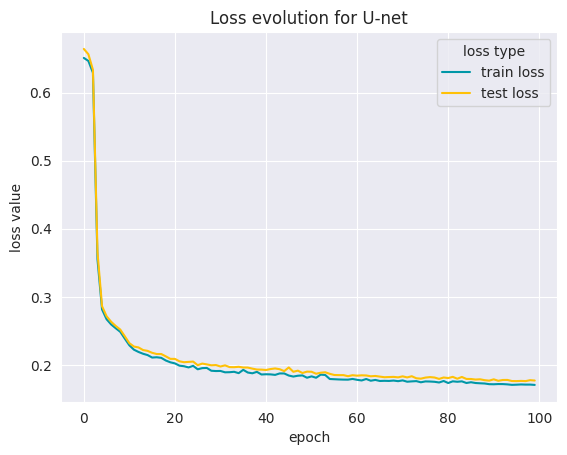

In [10]:
loss_values = (
    loss_values[["train loss", "test loss"]].melt().rename({"variable": "loss type", "value": "loss value"}, axis=1)
)
loss_values["epoch"] = 2 * list(range(loss_values.shape[0] // 2))

sns.lineplot(data=loss_values, x="epoch", y="loss value", hue="loss type", palette=["#0097A7", "#FFC107"])
plt.title("Loss evolution for U-net")
plt.savefig("./resources/loss_evolution_watermark_removal.png", dpi=200)
plt.show()


## Infer using the network
To use the network you need first to run the cells corresponding to imports, architecture definition and data loading

In [11]:
def inverse_normalize(tensor):
    # the images fed to the network have normalized pixels and this function applies the inverse operation so that the values are between 0 and 255
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    tensor = tensor * std + mean

    return tensor

In [12]:
plt.style.use("default")

# load the network
loaded_unet = UNet(3, 3)
loaded_unet.load_state_dict(torch.load("./models/watermark_removal.pth"))
loaded_unet.eval()
loaded_unet = loaded_unet.to(DEVICE)

# store in the lists below all the images from the test set as numpy arrays
images_with_watermark = []
images_cleaned = []
images_without_watermark = []

# removes the watermark from each test image and converts each image to a numpy array with values between 0 and 255
with torch.no_grad():
    for (x_w_watermark, _), (x_wo_watermark, _) in zip(test_loader_w_watermark, test_loader_wo_watermark):
        predicted_clean_images = loaded_unet(x_w_watermark.to(DEVICE))

        for image_with_watermark in x_w_watermark:
            images_with_watermark.append(
                np.transpose(inverse_normalize(image_with_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for image_without_watermark in x_wo_watermark:
            images_without_watermark.append(
                np.transpose(inverse_normalize(image_without_watermark).cpu().numpy()[0], (1, 2, 0))
            )
        for clean_image in predicted_clean_images:
            images_cleaned.append(np.transpose(inverse_normalize(clean_image.to("cpu")).cpu().numpy()[0], (1, 2, 0)))


### Display and store a set of image triplets (with watermark, cleaned, without watermark)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


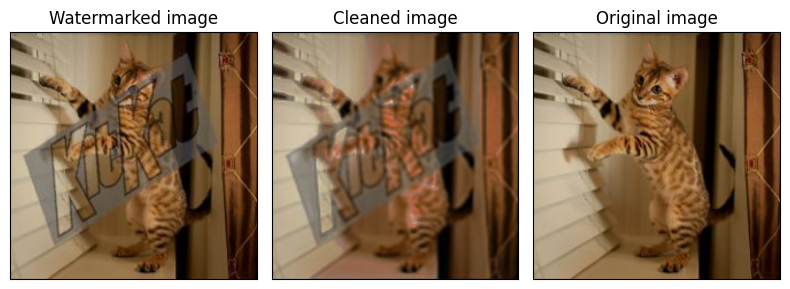

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


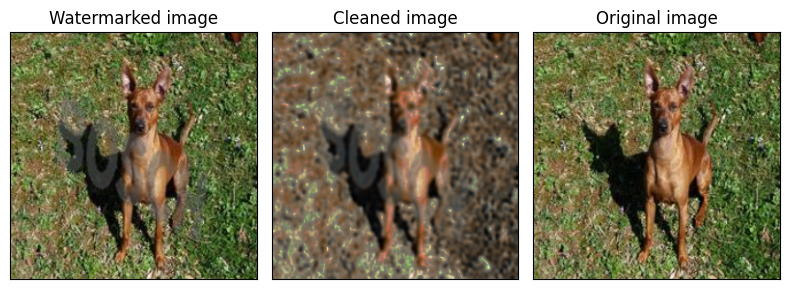

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


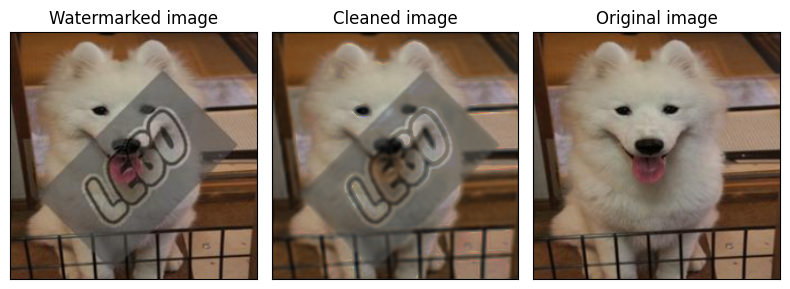

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


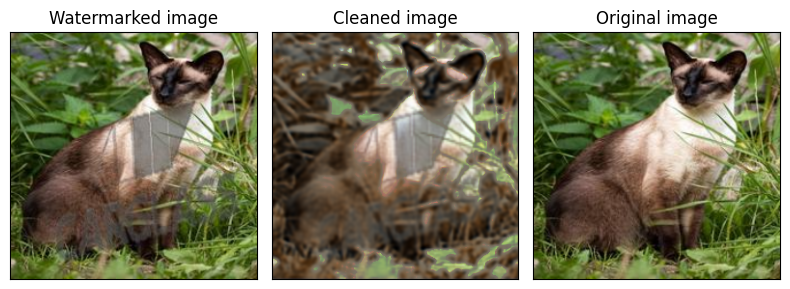

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


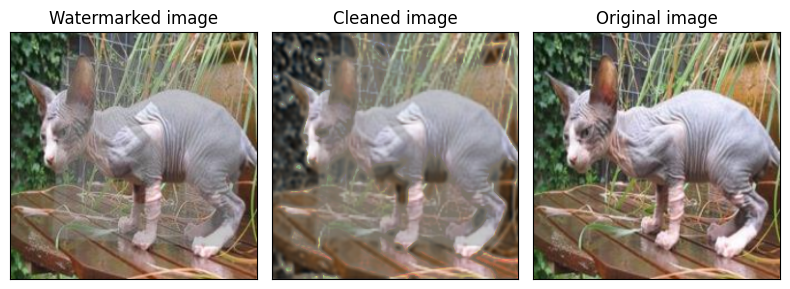

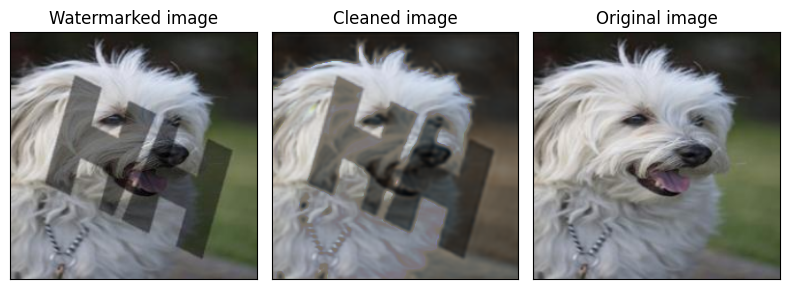

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


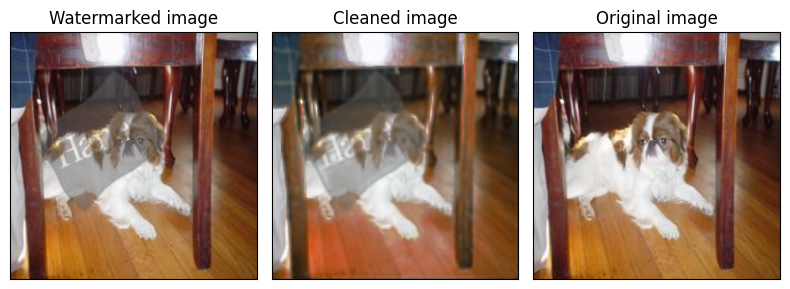

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


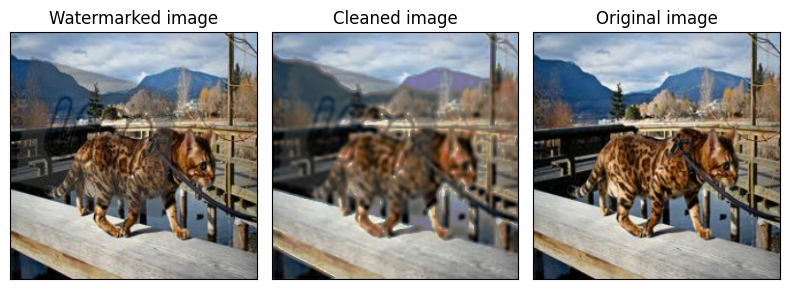

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


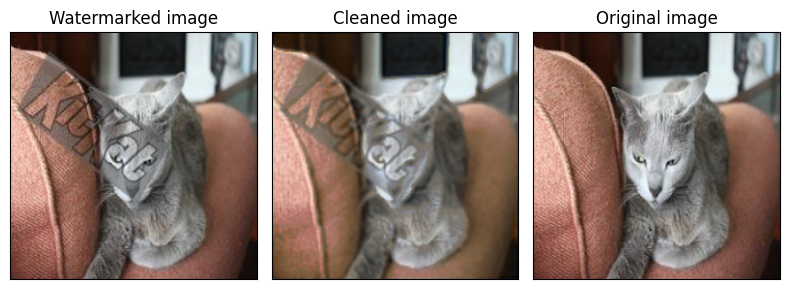

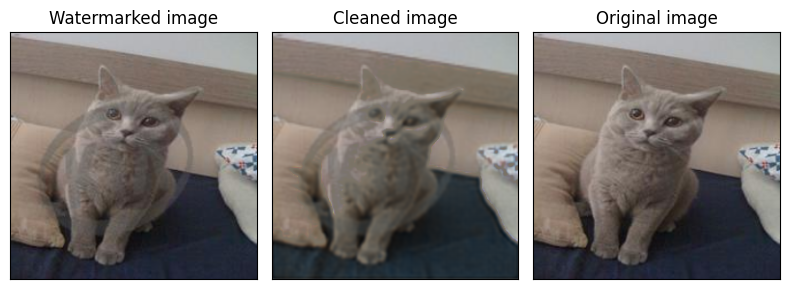

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


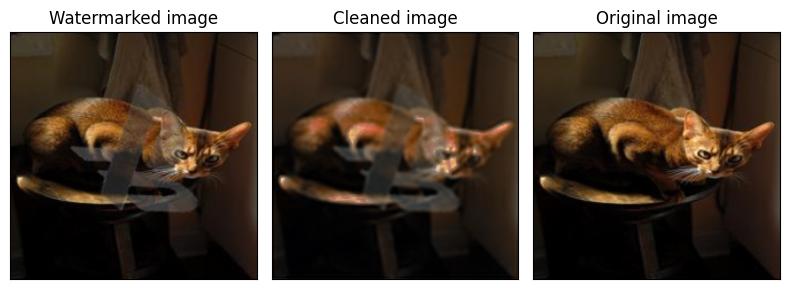

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


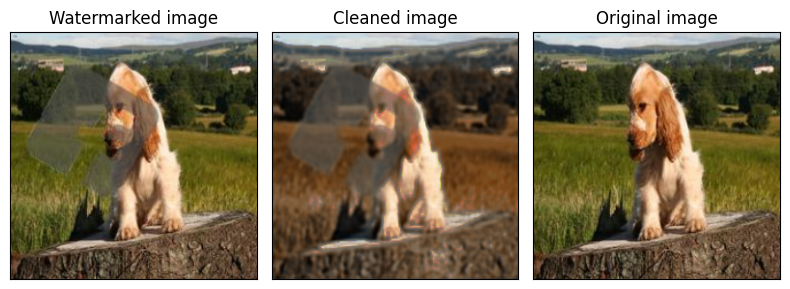

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


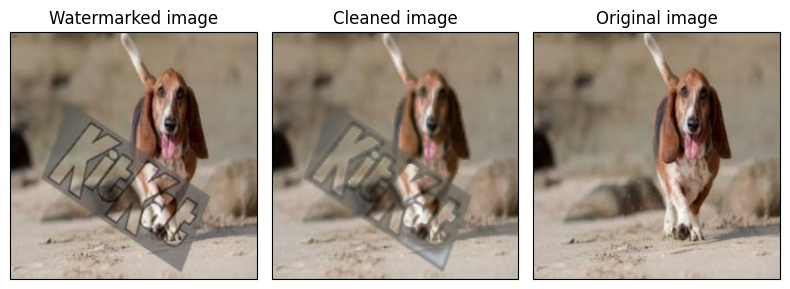

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


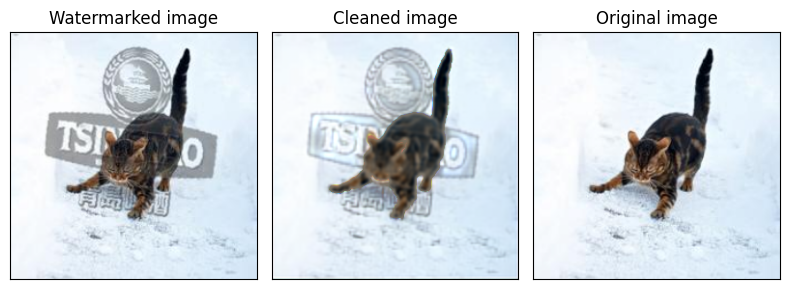

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


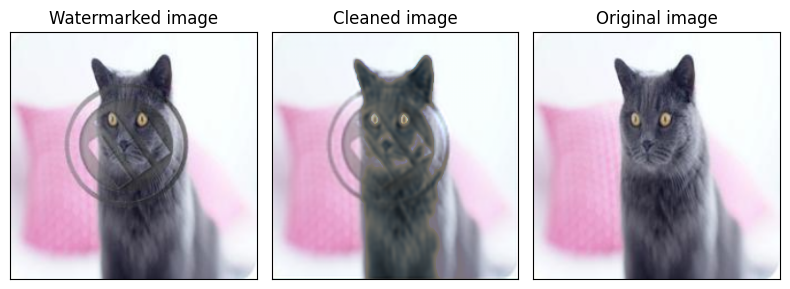

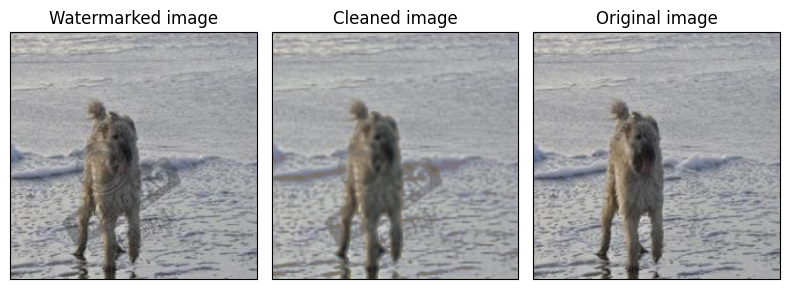

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


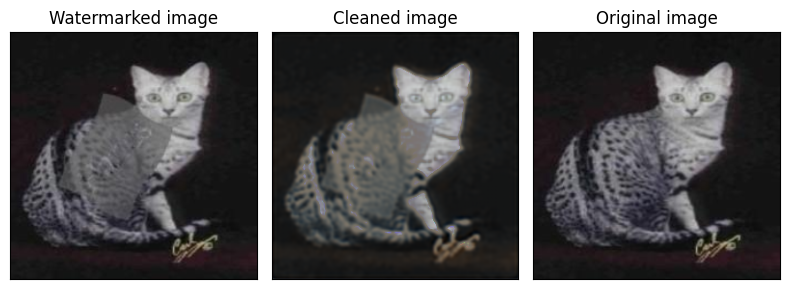

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


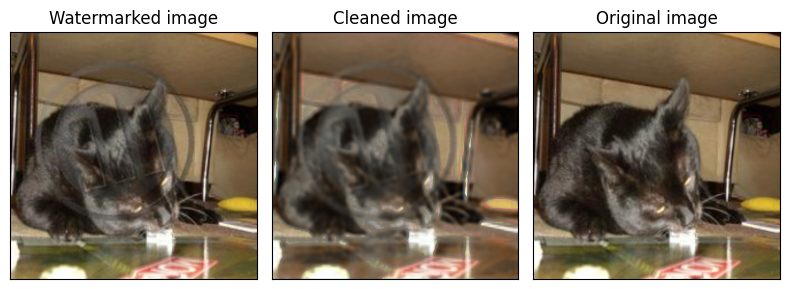

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


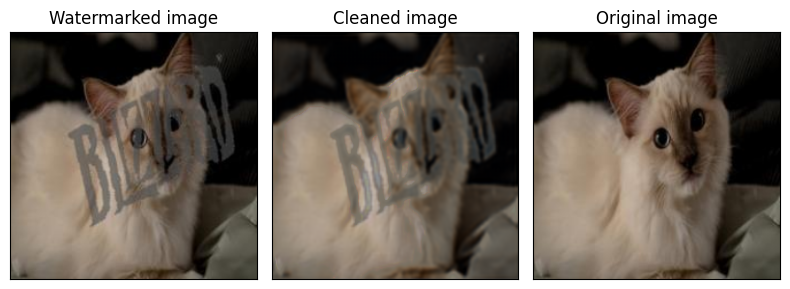

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


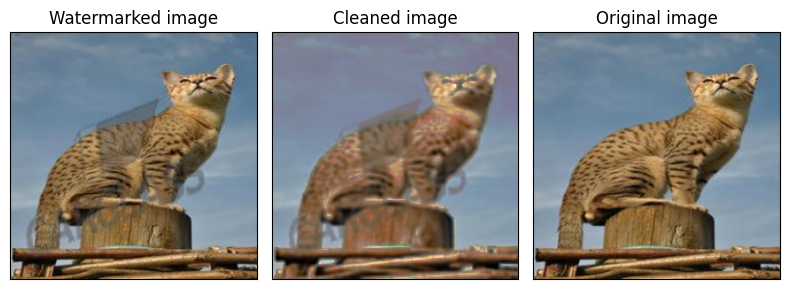

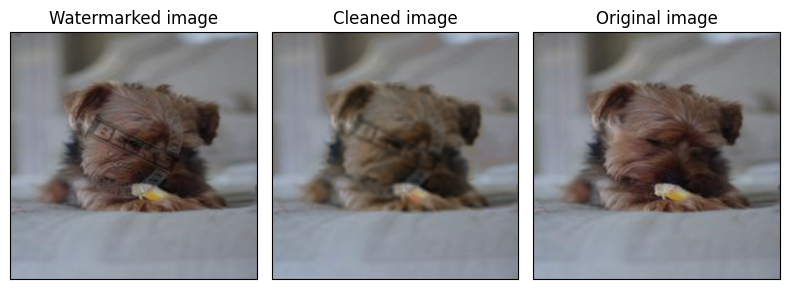

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


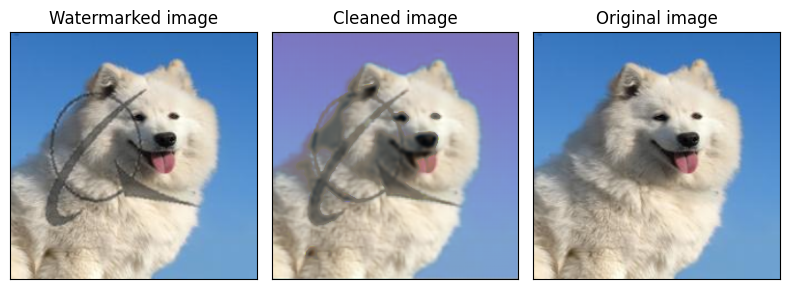

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


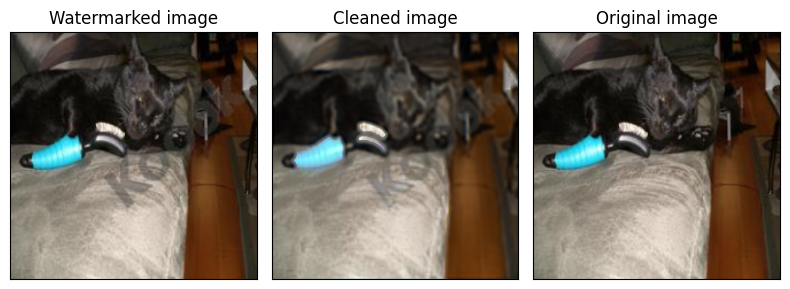

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


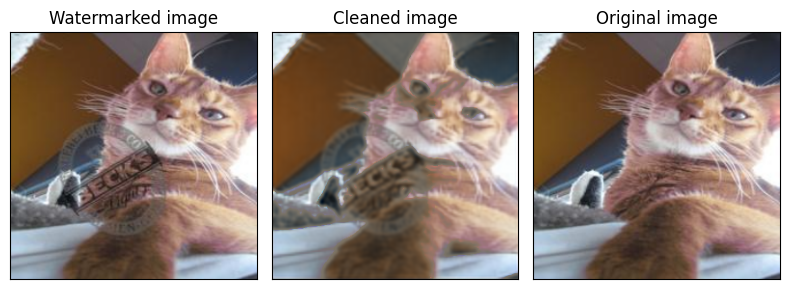

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


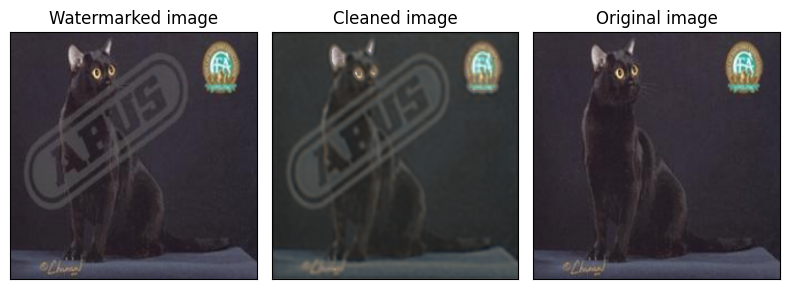

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


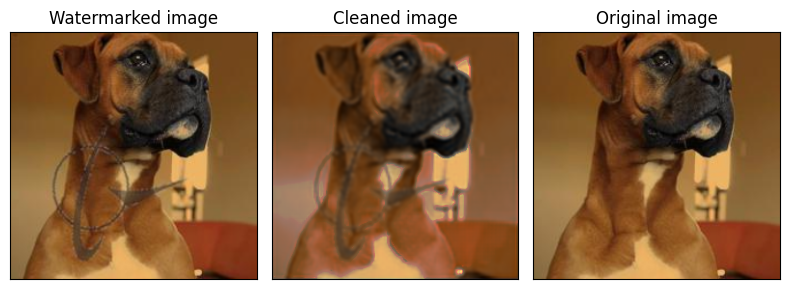

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


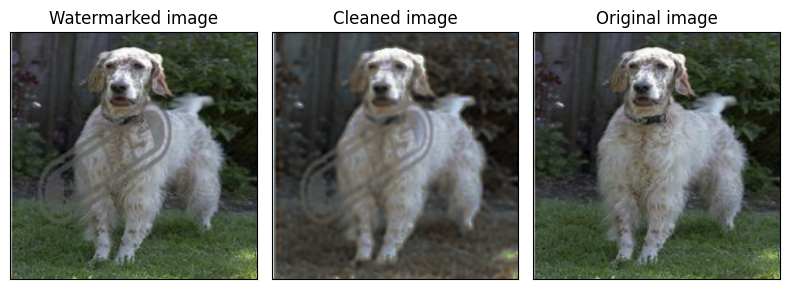

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


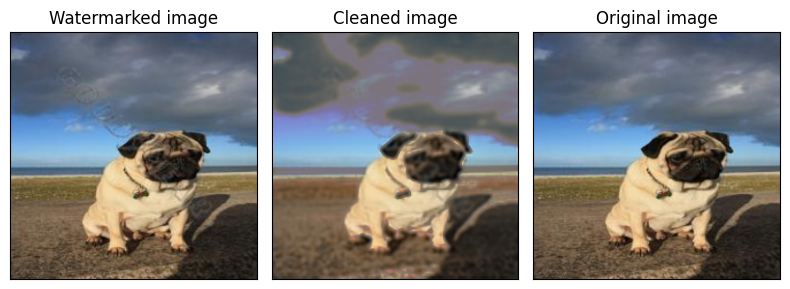

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


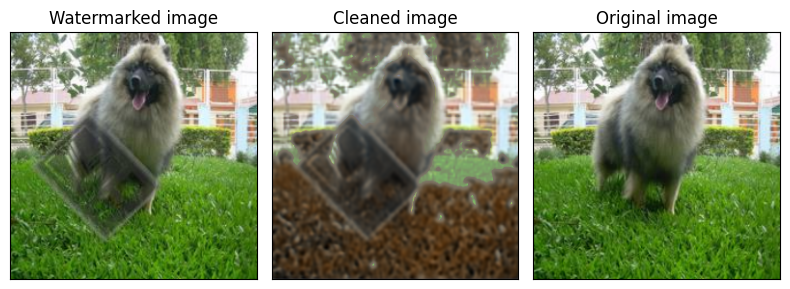

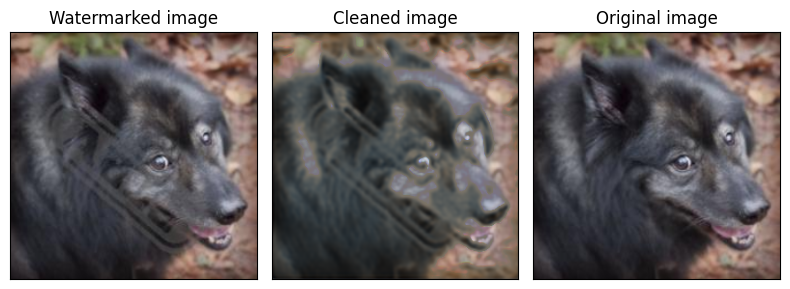

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


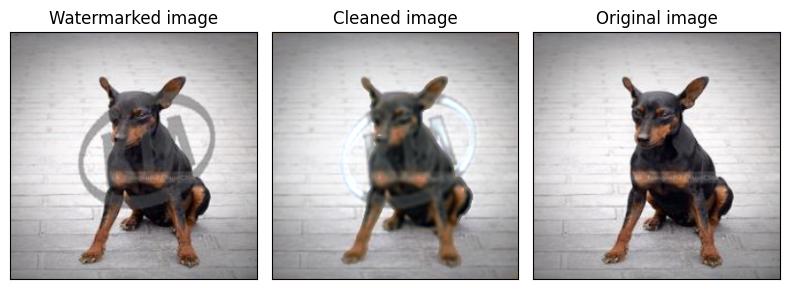

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


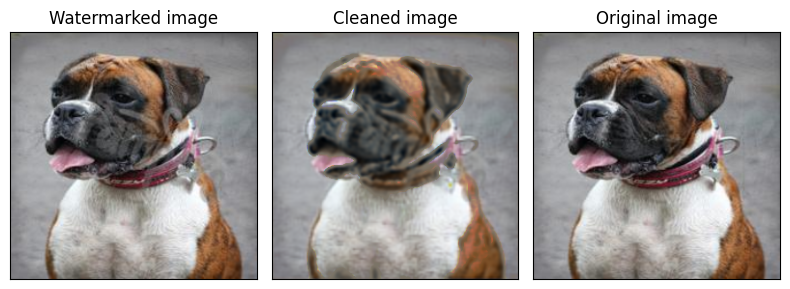

In [15]:
show_images_no = 32

for image_index in range(show_images_no):
    fig, axes = plt.subplots(1, 3, figsize=(8, 12))
    axes[0].imshow(images_with_watermark[image_index])
    axes[0].set_title("Watermarked image")
    axes[1].imshow(images_cleaned[image_index])
    axes[1].set_title("Cleaned image")
    axes[2].imshow(images_without_watermark[image_index])
    axes[2].set_title("Original image")

    for i in range(3):
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()

    plt.savefig(
        f"./resources/watermark_removal_sample_{image_index}.png", dpi=200, bbox_inches="tight"
    )
    plt.show()


### Store all test images with watermarks removed

In [14]:
cleaned_images_paths = (
    test_data_w_watermark["image_path"].map(lambda x: x.replace("images_with_logos", "images_cleaned")).to_list()
)

for image_index in range(len(cleaned_images_paths)):
    cleaned_to_store = Image.fromarray((images_cleaned[image_index] * 255).astype(np.uint8)).resize((224, 224))
    cleaned_to_store.save(cleaned_images_paths[image_index])
